# Time Series

## Analysis Plan



In [1]:
from IPython.display import display

import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
import pyrasterframes.rf_ipython

from pyspark.sql.functions import udf, lit
from geomesa_pyspark.types import MultiPolygonUDT

# This job is more memory bound, so reduce the concurrent tasks.
spark = create_rf_spark_session("local[4]")


In this example, we will show how the flexibility of the DataFrame concept for raster data allows a simple and intuitive way to extract a time series from Earth observation data. We will continue our example from the @ref:[Zonal Map Algebra page](zonal-algebra.md).

We will summarize the change in @ref:[NDVI](local-algebra.md#computing-ndvi) over the spring and early summer of 2018 in the Cuyahoga Valley National Park in Ohio, USA. 



In [2]:
cat = spark.read.format('aws-pds-modis-catalog').load().repartition(200)
import requests
nps_filepath = '/tmp/parks.geojson'
nps_data_query_url = 'https://services1.arcgis.com/fBc8EJBxQRMcHlei/arcgis/rest/services/' \
                     'NPS_Park_Boundaries/FeatureServer/0/query' \
                     '?geometry=-82.451,41.075,-80.682,41.436&inSR=4326&outSR=4326&outFields=*&f=geojson'
r = requests.get(nps_data_query_url)
with open(nps_filepath,'wb') as f:
    f.write(r.content)

park_vector = spark.read.geojson(nps_filepath)

@udf(MultiPolygonUDT())
def simplify(g, tol):
    return g.simplify(tol)

park_vector = park_vector.withColumn('geo_simp', simplify('geometry', lit(0.001))) \
                         .select('geo_simp') \
                         .hint('broadcast')


## Catalog Read

As in our other example, we will query for a single known MODIS granule directly. We limit the vector data to the single park of interest. The longer time period selected should show the change in plant vigor as leaves emerge over the spring and into early summer. The definitions of `cat` and `park_vector` are as in the @ref:[Zonal Map Algebra page](zonal-algebra.md). 



In [3]:
park_cat = cat \
            .filter(
                    (cat.granule_id == 'h11v04') &
                    (cat.acquisition_date > lit('2018-02-19')) &
                    (cat.acquisition_date < lit('2018-07-01'))            
                    ) \
            .crossJoin(park_vector.filter('OBJECTID == 380')) #only coyahuga


## Vector and Raster Data Interaction

We follow the same steps as the Zonal Map Algebra analysis: reprojecting the park geometry, filtering for intersection, rasterizing the geometry, and masking the NDVI by the _zone_ _tiles_. The code from that analysis is condensed here for reference.



In [4]:
raster_cols = ['B01', 'B02',] # red and near-infrared respectively

rf_park_tile = spark.read.raster(
        park_cat.select(['acquisition_date', 'granule_id', 'geo_simp'] + raster_cols),
        catalog_col_names=raster_cols) \
    .withColumn('park_native', st_reproject('geo_simp', lit('EPSG:4326'), rf_crs('B01'))) \
    .filter(st_intersects('park_native', rf_geometry('B01'))) \
    .withColumn('dims', rf_dimensions('B01')) \
    .withColumn('park_tile', rf_rasterize('park_native', rf_geometry('B01'), lit(1), 'dims.cols', 'dims.rows')) \
    .withColumn('ndvi', rf_normalized_difference('B02', 'B01')) \
    .withColumn('ndvi_masked', rf_mask('ndvi', 'park_tile'))


## Create Time Series

We next aggregate across the cell values to arrive at an average NDVI for each week of the year. We use `pyspark`'s built in `groupby` and time functions with a RasterFrames @ref:[aggregate function](aggregation.md) to do this. Note that the computation is creating a weighted average, which is weighted by the number of valid observations per week. 



In [5]:
from pyspark.sql.functions import col, year, weekofyear, month

time_series = rf_park_tile \
        .groupby(
            year('acquisition_date').alias('year'), 
            weekofyear('acquisition_date').alias('week')) \
        .agg(rf_agg_mean('ndvi_masked').alias('ndvi'))


Finally, we will take a look at the NDVI over time.



Text(0.5,1,'Cuyahoga Valley NP Green-up')

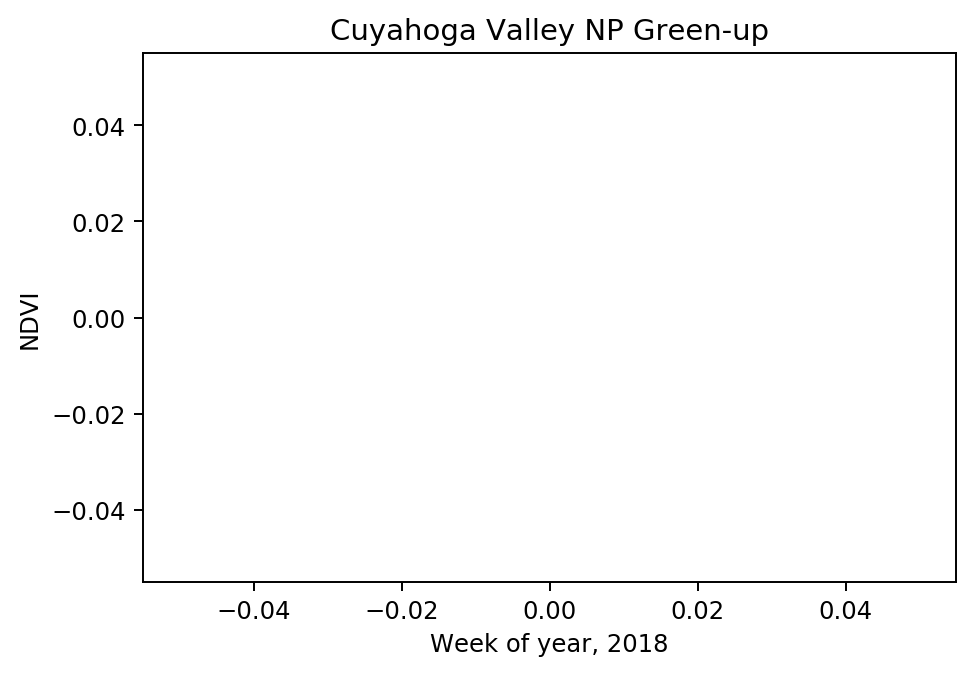

In [6]:
import matplotlib.pyplot as plt

time_series_pdf = time_series.toPandas()
time_series_pdf.sort_values('week', inplace=True)
plt.plot(time_series_pdf['week'], time_series_pdf['ndvi'], 'go-')
plt.xlabel('Week of year, 2018')
plt.ylabel('NDVI')
plt.title('Cuyahoga Valley NP Green-up')


We can see two fairly clear elbows in the curve at week 17 and week 21, indicating the start and end of the green up period. Estimation of such parameters is one technique [phenology](https://en.wikipedia.org/wiki/Phenology) researchers use to monitor changes in climate and environment.
